<a href="https://colab.research.google.com/github/WinetraubLab/coregister-xy/blob/main/locate-oct-on-fluorescent.ipynb" target="_blank">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

<a href="https://github.com/WinetraubLab/coregister-xy/blob/main/locate-oct-on-fluorescent.ipynb" target="_blank">
  <img src="https://img.shields.io/badge/view%20in-GitHub-blue" alt="View in GitHub"/>
</a>

# Overview
Use this notebook to draw OCT location on fluorescent image. Image must be pre-aligned to template.


In [1]:
# @title Notebook Inputs { display-mode: "form" }
# @markdown Input Image Paths:
# @markdown Leave either image path blank to load a file from local file system.
fluorescent_image_path = "/content/drive/Shareddrives/Yolab - Current Projects/Emilie/Brain/CosMx to OCT alignment BT63.3 /04 fluorescent aligned and template (no box)/s4s1/s4s1_f.tif" # @param {type:"string"}

# @markdown To obtain the template image file, run [this code](https://github.com/WinetraubLab/coregister-xy/blob/main/pattern/script_SimulatePhotobleachPatternIn3D.m). The output will be a multi-page TIFF file.
# @markdown Input the path to the multi-page or single-page TIFF, or leave blank to upload from local file system:

template_image_path = "/content/drive/Shareddrives/Yolab - Current Projects/Emilie/out_xy_V9.tiff" # @param {type:"string"}

# @markdown region of interest (ROI)
roi = "5"# @param {type:"string"}

if roi == "1":
  start_zdepth = 0
if roi == "2":
  start_zdepth =  100
if roi == "4":
  start_zdepth = 200

# @markdown Optional: If template image is multi-page, specify slice number. Use 1 as default.
slice_number = 199 # @param {type:"integer"}

oct_size_um = 500 # Length of one side of the OCT volume
template_um_per_pixel = 1

import cv2 as cv
from PIL import Image
import numpy as np
from google.colab import drive
drive.mount('/content/drive/')

if not fluorescent_image_path:
  print("Upload Fluorescent Image:")
  uploaded = files.upload()
  fluorescent_image_path = list(uploaded.keys())[0]
  fluorescent_image_path = os.path.join(os.getcwd(), fluorescent_image_path)
if not template_image_path:
  print("\nUpload Template Image:")
  uploaded = files.upload()
  template_image_path = list(uploaded.keys())[0]
  template_image_path = os.path.join(os.getcwd(), template_image_path)

# Open the template and check if it is a multi-page TIFF file
ret, images = cv.imreadmulti(template_image_path)
assert ret, "Failed to load template image file"
if slice_number > len(images):
  raise ValueError(f"Slice number {slice_number} is out of range")
source_image = images[slice_number - 1]

target_image = cv.imread(fluorescent_image_path)

assert source_image is not None and target_image is not None, "Failed to load image"
num_channels = source_image.shape[2] if len(source_image.shape) == 3 else 1

Mounted at /content/drive/


In [2]:
# @title Environment Setup

import matplotlib.pyplot as plt
import os
from google.colab import files
import math

%cd ..

/


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

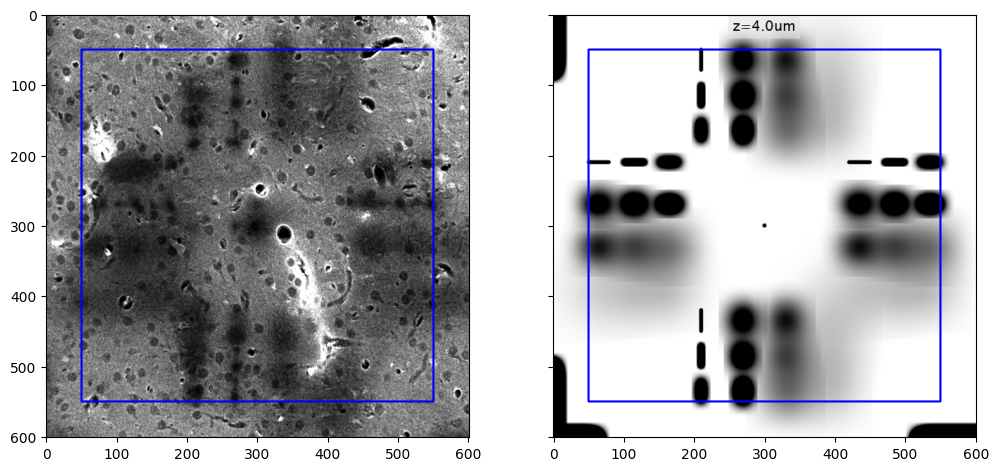

In [7]:
# @title Add OCT view

transformed_center = source_image.shape[0] // 2, source_image.shape[1] // 2

bottom_left_x = transformed_center[0] - oct_size_um // 2
bottom_left_y = transformed_center[1] - oct_size_um // 2

template = cv.cvtColor(source_image, cv.COLOR_GRAY2RGB)
fluorescent = target_image.copy()

corners = np.array(((bottom_left_x, bottom_left_y), (bottom_left_x + oct_size_um, bottom_left_y), (bottom_left_x + oct_size_um, bottom_left_y + oct_size_um), (bottom_left_x, bottom_left_y + oct_size_um)))
corners_transformed = corners
corners_transformed = np.array(corners_transformed)
corners = corners_transformed.reshape((-1, 1, 2))
cv.polylines(fluorescent, np.int32([corners]), isClosed=True, color=(0, 0, 255), thickness=2)
cv.polylines(template, np.int32([corners]), isClosed=True, color=(0, 0, 255), thickness=2)

im_height, im_width = template.shape[:2]
x2, y2 = min(im_width, fluorescent.shape[1]), min(im_height, fluorescent.shape[0])
fluorescent = fluorescent[:y2, :x2]

cv.imwrite("fluorescent-with-box.png",cv.cvtColor(fluorescent, cv.COLOR_RGB2BGR))
files.download("fluorescent-with-box.png")

fig,ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(12,6))
ax[0].imshow(fluorescent)
ax[1].imshow(template)